In [1]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import xarray as xr
from pathlib import Path
from shapely.geometry import Polygon, Point

# Section 1: Correlation of fire intensity and environment factors

Fire intensity is measured using the total fire radiative power (GW) derived from satellite products within the study region (see SatelliteFire.ipynb). Environmental factors are represented by variables from the ERA5 dataset, the fifth-generation ECMWF atmospheric reanalysis of the global climate, after preprocessing. This analysis focuses on data from January 7 to January 12, 2025.

In [2]:
# load FRP data
frp_pali = xr.open_dataset("Total_FRP/total_frp_palisades.nc")
frp_eaton = xr.open_dataset("Total_FRP/total_frp_eaton.nc")

In [3]:
# load ERA5 data
era5 = xr.open_dataset("ERA5/ERA_5_Land_Hourly_Data.nc")
# slice to the time period of interest
era5_sliced = era5.sel(valid_time=slice("2025-01-05", "2025-01-13"))

# load fire perimeter
fire_perimeter = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/fires_perimeter.geojson")
fire_perimeter = fire_perimeter.to_crs(32611)

In [4]:
# function to clip raster to fire perimeter and take the region-mean (adopted from K.KayDee)
def clip_raster_to_area(arr, reference_gdf):
    
    # Make sure the dataset has CRS information
    arr = arr.rio.write_crs("EPSG:32611")    

    eaton_clipped = arr.rio.clip([reference_gdf.iloc[0].geometry], all_touched=True).mean({'x','y'}) 
    palisades_clipped = arr.rio.clip([reference_gdf.iloc[1].geometry], all_touched=True).mean({'x','y'}) 

    return eaton_clipped, palisades_clipped

### Temperature

In [5]:
# Raster for Palisades & Eaton 
eaton_temp_da, palisades_temp_da = clip_raster_to_area(era5_sliced.t2m, fire_perimeter)

In [14]:
pali_temp_mean = palisades_temp_da.resample(valid_time='1D').mean()
pali_temp_max = palisades_temp_da.resample(valid_time='1D').max()

eaton_temp_mean = eaton_temp_da.resample(valid_time='1D').mean()
eaton_temp_max = eaton_temp_da.resample(valid_time='1D').max()

Text(0, 0.5, '(F)')

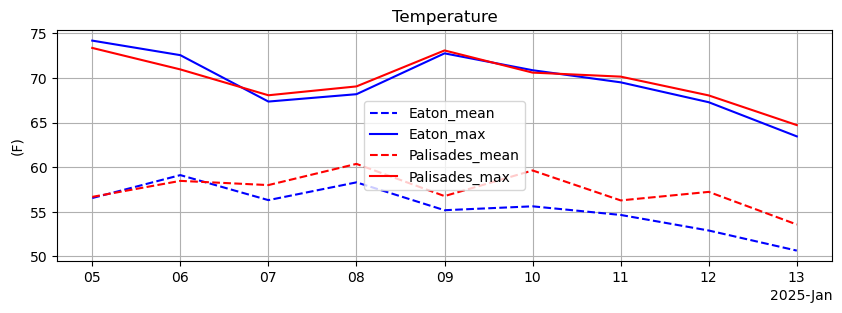

In [67]:
# visualize the daily value

fig,ax = plt.subplots(figsize=(10,3))
eaton_temp_mean.plot(ax=ax, label='Eaton_mean', color='b', linestyle='--')
eaton_temp_max.plot(ax=ax, label='Eaton_max', color='b', linestyle='-')

pali_temp_mean.plot(ax=ax, label='Palisades_mean', color='r', linestyle='--')
pali_temp_max.plot(ax=ax, label='Palisades_max', color='r', linestyle='-')

ax.legend()
ax.grid()
ax.set_title('Temperature')
ax.set_xlabel('')
ax.set_ylabel('(F)')

### Wind Magnitude

In [28]:
# calculate the magnitude
era5_sliced['wind_mag'] = np.sqrt(era5_sliced.u10**2 + era5_sliced.v10**2)
# Raster for Palisades & Eaton 
eaton_wind_da, palisades_wind_da = clip_raster_to_area(era5_sliced.wind_mag, fire_perimeter)

In [68]:
# resample to daily value

pali_wind_mean = palisades_wind_da.resample(valid_time='1D').mean()
pali_wind_max = palisades_wind_da.resample(valid_time='1D').max()

eaton_wind_mean = eaton_wind_da.resample(valid_time='1D').mean()
eaton_wind_max = eaton_wind_da.resample(valid_time='1D').max()

Text(0, 0.5, '(m/s)')

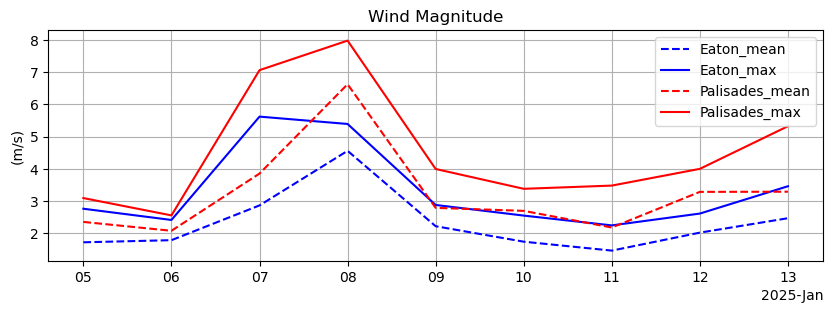

In [69]:
# visualize the daily value

fig,ax = plt.subplots(figsize=(10,3))
eaton_wind_mean.plot(ax=ax, label='Eaton_mean', color='b', linestyle='--')
eaton_wind_max.plot(ax=ax, label='Eaton_max', color='b', linestyle='-')

pali_wind_mean.plot(ax=ax, label='Palisades_mean', color='r', linestyle='--')
pali_wind_max.plot(ax=ax, label='Palisades_max', color='r', linestyle='-')

ax.legend()
ax.grid()
ax.set_title('Wind Magnitude')
ax.set_xlabel('')
ax.set_ylabel('(m/s)')

### Precipitation

In [48]:
# Raster for Palisades & Eaton 
eaton_preci_da, palisades_preci_da = clip_raster_to_area(era5_sliced.tp, fire_perimeter)

In [49]:
# resample to daily value, take the sum for precipitation
pali_preci_sum = palisades_preci_da.resample(valid_time='1D').sum()
eaton_preci_sum = eaton_preci_da.resample(valid_time='1D').sum()

### Specific Humidity
kg of water vapor per kg of air

In [53]:
humidity = xr.open_dataset("ERA5/humidity.nc")

# slice to the time period of interest
humidity_sliced = humidity.sel(valid_time=slice("2025-01-05", "2025-01-13"))

In [57]:
print(humidity_sliced.data_vars)

Data variables:
    __xarray_dataarray_variable__  (valid_time, y, x) float32 247kB ...


In [58]:
# rename the variable for easy call
humidity_sliced = humidity_sliced.rename({"__xarray_dataarray_variable__": "humidity"})

In [60]:
eaton_humi_da, palisades_humi_da = clip_raster_to_area(humidity_sliced.humidity, fire_perimeter)

In [64]:
# resample to daily value

pali_humi_mean = palisades_humi_da.resample(valid_time='1D').mean()
eaton_humi_mean = eaton_humi_da.resample(valid_time='1D').mean()

## Heatmap show correlation

In [89]:
# Convert 'FRP' and 'ACQ_DATE' from the frp_pali dataset to DataFrame
frp_df = frp_pali[['ACQ_DATE', 'FRP']].to_dataframe().reset_index()
frp_df['valid_time'] = pd.to_datetime(frp_df['ACQ_DATE'])

# Convert other variables to DataFrames
pali_temp_mean_df = pali_temp_mean.to_dataframe().reset_index()
pali_temp_mean_df['valid_time'] = pd.to_datetime(pali_temp_mean_df['valid_time'])

pali_temp_max_df = pali_temp_max.to_dataframe().reset_index()
pali_temp_max_df['valid_time'] = pd.to_datetime(pali_temp_max_df['valid_time'])

pali_wind_mean_df = pali_wind_mean.to_dataframe().reset_index()
pali_wind_mean_df['valid_time'] = pd.to_datetime(pali_wind_mean_df['valid_time'])

pali_wind_max_df = pali_wind_max.to_dataframe().reset_index()
pali_wind_max_df['valid_time'] = pd.to_datetime(pali_wind_max_df['valid_time'])

pali_preci_sum_df = pali_preci_sum.to_dataframe().reset_index()
pali_preci_sum_df['valid_time'] = pd.to_datetime(pali_preci_sum_df['valid_time'])

pali_humi_mean_df = pali_humi_mean.to_dataframe().reset_index()
pali_humi_mean_df['valid_time'] = pd.to_datetime(pali_humi_mean_df['valid_time'])


# Merge all variables on 'valid_time' (keeping only colocated dates)
merged_data = pd.merge(frp_df, pali_temp_mean_df[['valid_time', 't2m']], on='valid_time', how='inner')
merged_data.rename(columns={'t2m': 'temp_mean'}, inplace=True)
merged_data = pd.merge(merged_data, pali_temp_max_df[['valid_time', 't2m']], on='valid_time', how='inner')
merged_data.rename(columns={'t2m': 'temp_max'}, inplace=True)
merged_data = pd.merge(merged_data, pali_wind_mean_df[['valid_time', 'wind_mag']], on='valid_time', how='inner')
merged_data.rename(columns={'wind_mag': 'wind_mean'}, inplace=True)
merged_data = pd.merge(merged_data, pali_wind_max_df[['valid_time', 'wind_mag']], on='valid_time', how='inner')
merged_data.rename(columns={'wind_mag': 'wind_max'}, inplace=True)
merged_data = pd.merge(merged_data, pali_preci_sum_df[['valid_time', 'tp']], on='valid_time', how='inner')
merged_data.rename(columns={'tp': 'precipitation'}, inplace=True)
merged_data = pd.merge(merged_data, pali_humi_mean_df[['valid_time', 'humidity']], on='valid_time', how='inner')

# Set 'valid_time' as the index
merged_data.set_index('valid_time', inplace=True)

In [91]:
merged_data_used = merged_data.iloc[:, 2:]
merged_data_used

,FRP,temp_mean,temp_max,wind_mean,wind_max,precipitation,humidity
valid_time,,,,,,,
2025-01-07,36250.30,57.995342,68.065750,3.851842,7.062788,0.030621,0.004814
2025-01-08,106765.81,60.371582,69.058914,6.625094,7.980366,0.014252,0.002128
2025-01-09,29653.15,56.760498,73.092659,2.787510,3.994188,0.000852,0.002707
2025-01-10,10777.05,59.634369,70.606232,2.694066,3.378756,0.022824,0.002112
2025-01-11,29687.54,56.276260,70.155571,2.176829,3.478609,0.007265,0.003237
2025-01-12,10.75,57.231873,68.048172,3.283501,3.998111,0.000852,0.002449


In [92]:
corr_matrix = merged_data_used.corr()

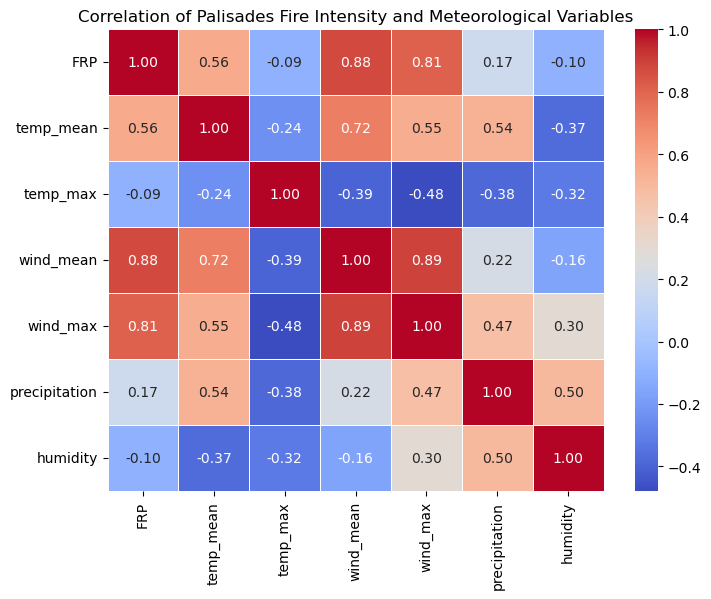

In [95]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of Palisades Fire Intensity and Meteorological Variables")

# plt.savefig("plots/heatmap_pali_env.png", format="png")
plt.show()

## Is there one-day lead?

In [100]:
# Original correlation (without shifting)
corr_with_frp_original = merged_data_used['FRP'].corr(merged_data_used['temp_mean'])
corr_with_frp_original_max = merged_data_used['FRP'].corr(merged_data_used['temp_max'])
corr_with_frp_wind_mean_original = merged_data_used['FRP'].corr(merged_data_used['wind_mean'])
corr_with_frp_wind_max_original = merged_data_used['FRP'].corr(merged_data_used['wind_max'])
corr_with_frp_preci_original = merged_data_used['FRP'].corr(merged_data_used['precipitation'])
corr_with_frp_humi_original = merged_data_used['FRP'].corr(merged_data_used['humidity'])

# Shift the environmental variables by 1 day ahead (lead of 1)
merged_data_used_lead = merged_data_used.shift(-1)  # Shift forward (lead)

# 1-day ahead (lead) correlation
corr_with_frp_lead = merged_data_used['FRP'].corr(merged_data_used_lead['temp_mean'])
corr_with_frp_lead_max = merged_data_used['FRP'].corr(merged_data_used_lead['temp_max'])
corr_with_frp_wind_mean = merged_data_used['FRP'].corr(merged_data_used_lead['wind_mean'])
corr_with_frp_wind_max = merged_data_used['FRP'].corr(merged_data_used_lead['wind_max'])
corr_with_frp_preci = merged_data_used['FRP'].corr(merged_data_used_lead['precipitation'])
corr_with_frp_humi = merged_data_used['FRP'].corr(merged_data_used_lead['humidity'])

# Print the original correlations
print("Original Correlation (without lag):")
print(f"Correlation between fire intensity (FRP) and temperature mean: {corr_with_frp_original:.2f}")
print(f"Correlation between fire intensity (FRP) and temperature max: {corr_with_frp_original_max:.2f}")
print(f"Correlation between fire intensity (FRP) and wind mean: {corr_with_frp_wind_mean_original:.2f}")
print(f"Correlation between fire intensity (FRP) and wind max: {corr_with_frp_wind_max_original:.2f}")
print(f"Correlation between fire intensity (FRP) and precipitation: {corr_with_frp_preci_original:.2f}")
print(f"Correlation between fire intensity (FRP) and humidity: {corr_with_frp_humi_original:.2f}")

# Print the 1-day ahead (lead) correlations
print("\n1-Day Ahead Correlation (with lag of 1):")
print(f"Correlation between fire intensity (FRP) and 1-day ahead temperature mean: {corr_with_frp_lead:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead temperature max: {corr_with_frp_lead_max:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead wind mean: {corr_with_frp_wind_mean:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead wind max: {corr_with_frp_wind_max:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead precipitation: {corr_with_frp_preci:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead humidity: {corr_with_frp_humi:.2f}")


Original Correlation (without lag):
Correlation between fire intensity (FRP) and temperature mean: 0.56
Correlation between fire intensity (FRP) and temperature max: -0.09
Correlation between fire intensity (FRP) and wind mean: 0.88
Correlation between fire intensity (FRP) and wind max: 0.81
Correlation between fire intensity (FRP) and precipitation: 0.17
Correlation between fire intensity (FRP) and humidity: -0.10

1-Day Ahead Correlation (with lag of 1):
Correlation between fire intensity (FRP) and 1-day ahead temperature mean: -0.19
Correlation between fire intensity (FRP) and 1-day ahead temperature max: 0.77
Correlation between fire intensity (FRP) and 1-day ahead wind mean: -0.04
Correlation between fire intensity (FRP) and 1-day ahead wind max: -0.00
Correlation between fire intensity (FRP) and 1-day ahead precipitation: -0.41
Correlation between fire intensity (FRP) and 1-day ahead humidity: -0.03


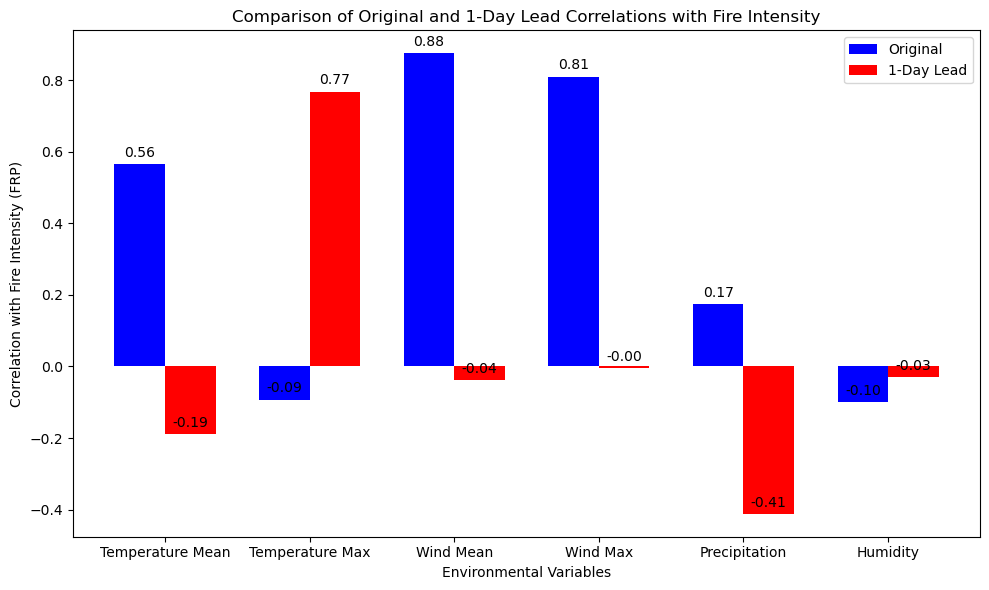

In [105]:
# Data for plotting
variables = ['Temperature Mean', 'Temperature Max', 'Wind Mean', 'Wind Max', 'Precipitation', 'Humidity']
original_corr = [
    corr_with_frp_original, 
    corr_with_frp_original_max, 
    corr_with_frp_wind_mean_original, 
    corr_with_frp_wind_max_original, 
    corr_with_frp_preci_original, 
    corr_with_frp_humi_original
]
lead_corr = [
    corr_with_frp_lead, 
    corr_with_frp_lead_max, 
    corr_with_frp_wind_mean, 
    corr_with_frp_wind_max, 
    corr_with_frp_preci, 
    corr_with_frp_humi
]

# Set the positions for the bars on the x-axis
x = np.arange(len(variables))
width = 0.35  # Width of the bars

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for original correlation and 1-day lead correlation
bars1 = ax.bar(x - width/2, original_corr, width, label='Original', color='b')
bars2 = ax.bar(x + width/2, lead_corr, width, label='1-Day Lead', color='r')

# Labeling
ax.set_xlabel('Environmental Variables')
ax.set_ylabel('Correlation with Fire Intensity (FRP)')
ax.set_title('Comparison of Original and 1-Day Lead Correlations with Fire Intensity')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

# Add the values on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to both sets of bars
add_labels(bars1)
add_labels(bars2)

# Display the plot
plt.tight_layout()
plt.show()
